In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install opencv-python

In [0]:
import os
os.chdir("/content/drive/My Drive/Convolucionales UNAL/")

In [4]:
!ls

 cat.jpg
 checkpoint
 cnn_utils1.py
 convolutionalModel_restore_prediction_full.ipynb
 convolutionalModel_train_full.ipynb
'Copia de convolutionalModel_train_full.ipynb'
 datasets
 dog.jpg
 imagen_test1.jpg
 imagen_test2.jpg
 model_softmax.ckpt.data-00000-of-00001
 model_softmax.ckpt.index
 model_softmax.ckpt.meta
 outputs
 __pycache__
 transfer_learning.ipynb
 Untitled0.ipynb


In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
import cv2


def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Crea los placeholders para la sesión.
    
    Argumentos:
    n_H0 -- Escalar, height de la imagen de entrada
    n_W0 -- Escalar, width de la imagen de entrada
    n_C0 -- Escalar, Número de canales de entrada
    n_y -- Escalar, Número de clases
        

    Returna:
    X -- placeholder para los datos de entrada, de tamaño [None, n_H0, n_W0, n_C0] y dtype "float"
    Y -- placeholder para las etiquetas de entrada, de tamaño [None, n_y] y dtype "float"
    """

    #### Haga su código acá ### (≈2 lines)

    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    
    ### Fin ###
    
    return X, Y
    
    
def initialize_parameters():
    """
    Inicializa los parámetros (Pesos) para construir la red neuronal convolucional con tensorflow. El tamaño es
                        W1 : [3, 3, 3, 4]
                        W2 : [3, 3, 4, 8]
    Returna:
    parameters -- Un diccionario de tensores que contiene W1, W2
    """
    
    tf.set_random_seed(1)                              # 
        
    #### Haga su código acá ### (≈2 lines)
        
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    ### Fin ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters


def forward_propagation(X, parameters):
    """
    Implementa la propagación hacia adelante del modelo

    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Argumentos:
    X -- placeholder de entrada (ejemplos de entrenamiento), de tamaño (input size, number of examples)
    parameters -- Diccionario que contiene los parámetros "W1", "W2" desde initialize_parameters

    Returna:
    Z3 -- Salida de la última unidad LINEAR 
    """
    
    # Obtención de los pesos desde "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    #### Haga su código acá ### 
    
    # CONV2D: stride of 1, padding 'SAME'
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    
    # RELU
    
    A1 = tf.nn.relu(Z1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    
    # RELU
    
    A2 = tf.nn.relu(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    # FLATTEN
    
    F = tf.contrib.layers.flatten(P2)
    
#    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
#    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    
    Z3 = tf.contrib.layers.fully_connected(F, 4, None)
    
    ### Fin ###

    return Z3
    

def compute_cost(Z3, Y):
    """
    Calcula la función de costo
    
    Argumentos:
    Z3 -- Salida del forward propagation (Salida de la última unidad LINEAR), de tamaño (6, Número de ejemplos)
    Y -- placeholders con el vector de etiquetas "true", del mismo tamaño que Z3

    Returns:
    cost - Tensor de la función de costo
    """
    
    #### Haga su código acá ### (≈2 lines)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    ### Fin ###
    
    return cost   
   

def model_predict(data_test, y_label, learning_rate = 0.009, num_epochs = 100, minibatch_size = 10, print_cost = True):
    """
    Implementa una Red Neuronal Convolucional de 3-Capas en Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Argumentos:
    learning_rate -- factor de aprendizaje en la optimización
    num_epochs -- Número de epocas en el ciclo de optimización
    minibatch_size -- Tamaño del minibatch
    print_cost -- True: imprime el costo cada 100 epocas
    
    Returna:
    train_accuracy -- Número Real, Accuracy del conjunto de entrenamiento (X_train)
    test_accuracy -- Número Real, Accuracy del conjunto de Test(X_test)
    parameters -- parameters aprendidos por el modelo. Estos pueden ser usados para predecir.
    """
    
    ops.reset_default_graph()                         # Permite correr nuevamente el modelo sin sobreescribir las tf variables
    tf.set_random_seed(1)                             #  (tensorflow seed)
    seed = 3         
    (m, n_H0, n_W0, n_C0) = data_test.shape             
    n_y = y_label.shape[1]                                   # 
    
    # Crear los PlaceHolders
          
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # Inicializar Parámetros
    
    parameters = initialize_parameters()
    
    # Forward propagation: Construir el forward propagation en el grafo de tensorflow
    
    Z3 = forward_propagation(X, parameters)
            
    saver = tf.train.Saver()
     
    # Iniciar la sesión 
    with tf.Session() as sess:
        
        saver.restore(sess, "model_softmax.ckpt")        
        print("Model restored.")        
               
        predict_op = tf.nn.softmax(Z3)  # Apply softmax to logits
        
        # Calcular la predicción 
      
        prediccion= tf.argmax(predict_op, 1).eval({X: data_test, Y: y_label})
        print (prediccion)
        print("prediccion:", prediccion)
                
        return prediccion
       

INFO:tensorflow:Restoring parameters from model_softmax.ckpt


INFO:tensorflow:Restoring parameters from model_softmax.ckpt


Model restored.
[2]
prediccion: [2]


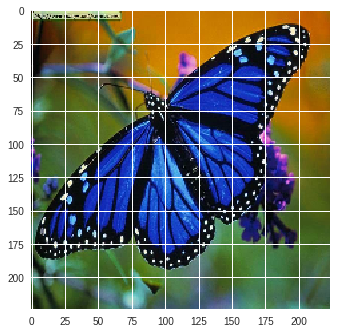

In [0]:
img = cv2.imread("imagen_test2.jpg")
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)#
img_test = img/255.
img_test=img_test[np.newaxis,...]
plt.figure(1)
plt.imshow(img)

y_label= np.array([0])
y_label = convert_to_one_hot(y_label, 4).T
#
prediccion = model_predict(img_test, y_label)